# Tiny Llama
#### Load packages

In [1]:
import torch
from transformers import pipeline

# For bertviz
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import utils
from bertviz import model_view, head_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

# For dataset
from datasets import load_dataset
from tqdm.notebook import tqdm

# For confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.is_available())

True


#### Load Tiny Llama Model

In [3]:
pipe = pipeline("text-generation", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", torch_dtype=torch.bfloat16, device_map="auto")
# pipe = pipeline("text-generation", model="TinyLlama/TinyLlama_v1.1", torch_dtype=torch.bfloat16, device_map="auto")

# For bertviz
# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.6", trust_remote_code=True)
# model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.6", device_map="cpu", trust_remote_code=True, attn_implementation="eager").eval()

In [4]:
# We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
# messages = [
#     {
#         "role": "system",
#         "content": "you're responeses are all lowercase",
#     },
#     {"role": "user", "content": "Write a poem about croissants."},
# ]
# prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# outputs = pipe(prompt, max_new_tokens=50, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
# print(outputs[0]["generated_text"])

# def prompt(prompt_text: str, vis: bool = False):
#     messages = [
#     {
#         "role": "system",
#         "content": "You answer multiple choice questions, therefore your answer must only contain either A, B or C.",
#     },
#     {f"role": "user", "content": prompt_text},
#     ]
#     prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
#     outputs = pipe(prompt, max_new_tokens=20, do_sample=True, temperature=0.2, top_k=50, top_p=0.95)
#     print(outputs[0]["generated_text"].split("<|assistant|>")[1])
#     print(type(outputs[0]["generated_text"]))
#     if vis:
#         inputs = tokenizer(prompt_text, return_tensors='pt')
#         out = model(**inputs, output_attentions=True)
#         attention = out['attentions']  # Retrieve attention from model outputs
#         tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])  # Convert input ids to token strings
#         # tokens = [item.decode() for item in tokens] # byte to str
#         head_view(attention, tokens)  # Display model view

In [18]:
# prompt1 = """
# Given this news text: Politics an Afterhought Amid Huricane (AP) AP - If Hurricane Charley had struck three years ago, President Bush's tour through the wreckage of this coastal city would have been just the sort of post-disaster visit that other presidents have made to the scenes of storms, earthquakes, floods and fires.

# In which section of a newspaper would the text appear? A: World News, B: Business or C: Science and Technology
# """
# prompt(prompt1, False)


The news text appears in the Business or C: Science and Technology section of a newspaper.
<class 'str'>


In [ ]:
prompt("write a poem", False)

#### Dataset

In [5]:
# Load sentiment dataset
glue_dataset = load_dataset("nyu-mll/glue", "sst2", split="validation")
amazon_dataset = load_dataset("fancyzhx/amazon_polarity", split="test")
ag_news_dataset = load_dataset("fancyzhx/ag_news", split="test")

##### Sentiment dataset

In [4]:
def sent_classifier(prompt: str, dataset, n_samples: int, shuffle: bool = True):
    if shuffle: dataset = dataset.shuffle()
    
    sentences = dataset["content"][:n_samples]
    labels = dataset["label"][:n_samples]
    predicted_labels = []
    for sentence in tqdm(sentences,total=n_samples):
        prompt1 = prompt.replace("SENTENCE", sentence)
        messages = [
        {
            "role": "system",
            "content": "You classify sentences as possitive or negative.",
        },
        {f"role": "user", "content": prompt1},
        ]
        prompt2 = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        outputs = pipe(prompt2, max_new_tokens=100, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
        answer = outputs[0]["generated_text"].split("<|assistant|>")[1]
        # print(answer, "\n ------------------------------")

        answer = answer.lower()

        if 'positive' in answer and 'negative' in answer:
            # unknown
            predicted_labels.append(-1) 
        elif 'positive' in answer:
            # positive
            predicted_labels.append(1)
        elif 'negative' in answer:
            # negative
            predicted_labels.append(0)
        else:
            # unkown
            predicted_labels.append(-1) 

    return predicted_labels, labels
    

  0%|          | 0/5 [00:00<?, ?it/s]

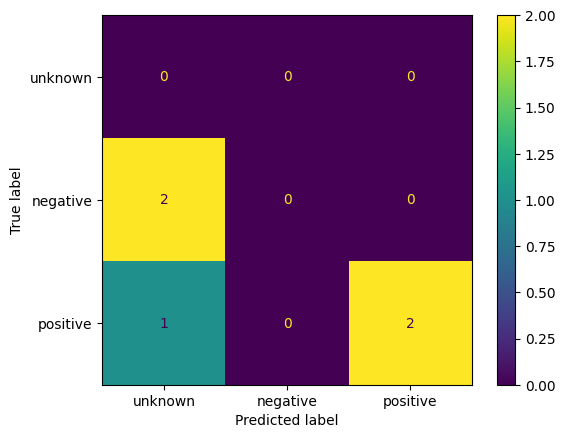

In [6]:
prompt1 = """
    Sentence: " SENTENCE "

    Would you say this sentence is negative or positive?
    """

predicted, labels = sent_classifier(prompt1, amazon_dataset, 5, True)


confusion_matrix = metrics.confusion_matrix(labels, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=["unknown", "negative", "positive"])
cm_display.plot()
plt.show() 

In [ ]:
# correct = 0

# # for data in tqdm(amazon_dataset[:20]):
# #     sentence = data["content"]
# #     label = data["label"]
# sentences = amazon_dataset["content"][:20]
# labels = amazon_dataset["label"][:20]

# predicted = []

# for sentence, label in tqdm(zip(sentences, labels)):
    

#     prompt1 = f"""
#     Given this sentence: "{sentence}"

#     Your response should look like this: "This sentence is: [Positive or Negative]"
#     Do not repeat the sentence above!
#     Would you say this sentence is positive or negative?
#     """

#     pred = sent_classifier(prompt1)
#     predicted.append(pred)

#     if pred == label:
#         correct += 1

# confusion_matrix = metrics.confusion_matrix(labels, predicted)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=["unknown", "negative", "positive"])
# cm_display.plot()
# plt.show() 

##### News dataset

In [38]:
def news_classifier(prompt: str, dataset, n_samples: int, shuffle: bool = True):
    if shuffle: dataset = dataset.shuffle()
    
    sentences = dataset["text"][:n_samples]
    labels = dataset["label"][:n_samples]
    predicted_labels = []
    for sentence in tqdm(sentences,total=n_samples):
        prompt1 = prompt.replace("SENTENCE", sentence)
        messages = [
        {
            "role": "system",
            "content": "You classify sentences, you indicate in which part of the newspaper they appear, the possible sections are given to you by the prompt.",
        },
        {f"role": "user", "content": prompt1},
        ]
        prompt2 = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        outputs = pipe(prompt2, max_new_tokens=200, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
        answer = outputs[0]["generated_text"].split("<|assistant|>")[1]
        print(answer)

        answer = answer.lower()

        if 'world news' in answer:
            predicted_labels.append(1)
        elif 'sports' in answer or 'sport' in answer:
            predicted_labels.append(2)
        elif 'business' in answer:
            predicted_labels.append(3)
        elif 'science' in answer or 'technology' in answer:
            predicted_labels.append(4)
        else:
            predicted_labels.append(-1)

    return predicted_labels, labels
    

  0%|          | 0/10 [00:00<?, ?it/s]


Based on the given text, "US edge out Brazil for gold The United States beat Brazil 2-1 in extra time to win the women's Olympic football tournament.", it would be appropriate to categorize it under the "world news" category.

Based on the text, the category that best aligns with the possible sections of a newspaper is "business." The sentence "Dell recalls four million power adaptors" indicates that it is a news article about a business event, such as a recall or safety alert, related to Dell's products.

Based on the sentence "RSS Feeds Hunger for More Ads There's no such thing as a free lunch. And soon, there may be no such thing as an ad-free RSS feed, either," I would classify this text as being a news article. News articles are typically written to inform, educate, or entertain readers about current events or happenings. The topic of this text, "RSS Feeds Hunger for More Ads There's no such thing as a free lunch. And soon, there may be no such thing as an ad-free RSS feed, eithe

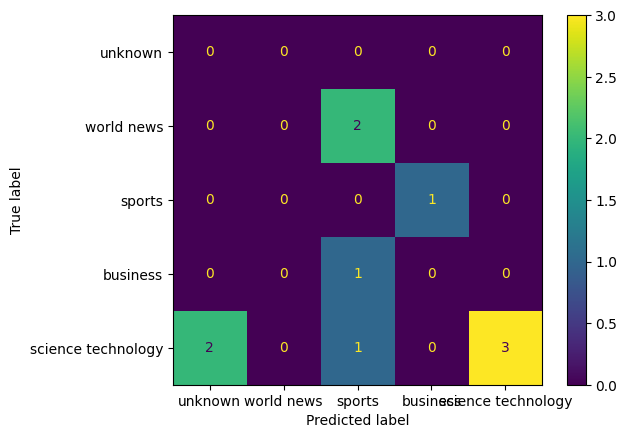

In [40]:
prompt1 = """
    Given this sentence: "SENTENCE"

    To which category of a newspaper do you think this text belongs? world news , sports , business or science technology ?
    """

predicted, labels = news_classifier(prompt1, ag_news_dataset, 10, True)


confusion_matrix = metrics.confusion_matrix(labels, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=["unknown", "world news", "sports", "business", "science technology"])
cm_display.plot()
plt.show() 